In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
import itertools

In [2]:
#rename column to remove spaces in column names
data=pd.read_csv('HistoricalQuotes.csv')
aapl =data.rename(columns={' Close/Last': 'close', ' Volume': 'volume',
                           ' Open':'open',' High':'high',' Low':'low'})
                        

#change date string into date format and sort the dataframe in ascending order
aapl[['Date']] = aapl[['Date']].applymap(lambda x: datetime.strptime(x,'%m/%d/%Y').date())
aapl =aapl.sort_values(by='Date')
#change dataframe dtypes to float
cols = [i for i in aapl if i not in ['Date','volume']]
def to_float(x):
    x = x.strip()
    return float(x[1:])

aapl[cols]=aapl[cols].applymap(to_float)

#Create Signals using Talib library
aapl['5EMA'] = ta.SMA(np.array(aapl['close']),5)
aapl['20EMA'] = ta.EMA(np.array(aapl['close']), timeperiod = 20)
aapl['RSI'] = ta.RSI(np.array(aapl['close']), timeperiod = 14)
aapl['WILLR'] = ta.WILLR(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['MOM'] = ta.MOM(np.array(aapl['close']), timeperiod=5)
aapl['CCI'] = ta.CCI(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['SLOWK'],aapl['SLOWD'] = ta.STOCH(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), fastk_period=14, slowk_period=3, slowd_period=3)
aapl['MACD'],aapl['MACDSIGNAL'],aapl['MACDHIST'] = ta.MACD(np.array(aapl['close']), fastperiod=12, slowperiod=26, signalperiod=9)
aapl['DMI'] = ta.DX(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)   

In [3]:
#  """Based on parameter setting adopted in Chen et al (2021) """
def generate_candidate_trading_signals(data):
    """Based on parameter setting adopted in Chen et al (2021) """
    conditions ={'TS1':[
                (data['5EMA'] > data['20EMA']),
                (data['5EMA'] < data['20EMA'])],
                 'TS2':[
                (data['RSI'] > 30),
                (data['RSI'] < 70),
                ],
                 'TS3':[
                (data['WILLR'] < 80),
                (data['WILLR'] > 20),
                ],
                 'TS4':[
                (data['MOM'] > 0 ),
                (data['MOM'] <= 0),
                ],
                 'TS5': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= 100),
                ],
                 'TS6': [
                (data['SLOWK'] > data['SLOWD']) & (data['SLOWD'] < 20),
                (data['SLOWK'] < data['SLOWD']) & (data['SLOWD'] > 80)],
                'TS7': [
                (data['MACD'] > 0 ),
                (data['MACD'] <= 0)],
                'TS8': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= -100)]}

    # create a list of the values we want to assign for each condition 1: buy, 0: sell
    values = [1, 0]

    # create a new column and use np.select to assign values to it using our lists as arguments
    for i in conditions:
        data[i] = np.select(conditions[i], values)
    strategies =list(conditions.keys())
    return data,strategies
#split data
train = aapl[(aapl['Date'] <= date(2019,12,31))]
test = aapl[(aapl['Date'] > date(2019,12,31))]
train_data, strategies =generate_candidate_trading_signals(train.copy())
test_data, test_strategies =generate_candidate_trading_signals(test.copy())

Running ring
GENERATION 0 START
Generation 0: Best fitness = 314.00215204264373 Average Fitness = 184.90319163211495
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 314.00215204264373 Average Fitness = 204.34409071050902
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 328.8444111799314 Average Fitness = 222.00323035159704
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 345.4801790725623 Average Fitness = 230.4755042908009
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 345.8597193921132 Average Fitness = 228.38673177020178
GENERATION 4 END
GENERATION 5 START
Generation 5: Best fitness = 345.8597193921132 Average Fitness = 246.18167874051562
GENERATION 5 END
GENERATION 6 START
Generation 6: Best fitness = 384.0758527590698 Average Fitness = 244.340852657842
GENERATION 6 END
GENERATION 7 START
Generation 7: Best fitness = 384.0758527590698 Average Fitness = 253.76083752497377
GENERATION 7 END
GENERATION 8 START
Generatio

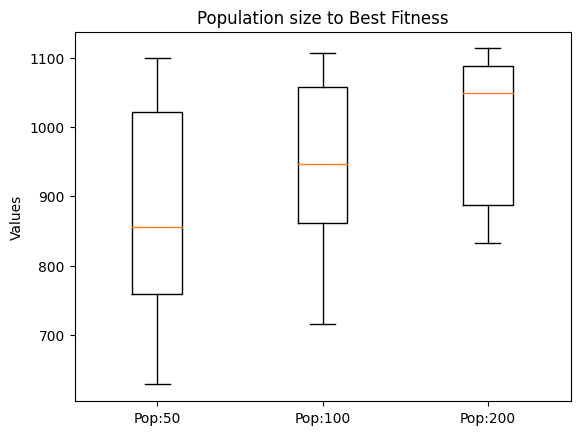

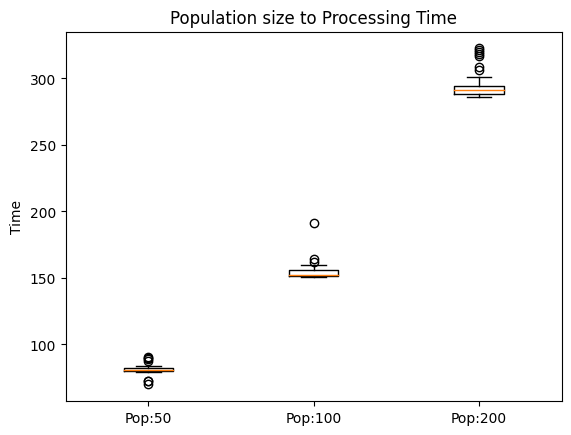

In [5]:
# ring
import matplotlib.pyplot as plt

fitness_values = {50:[],100:[],200:[]}
speed_values =  {50:[],100:[],200:[]}
pop_size =[50, 100, 200]

for i in pop_size:
    for j in range(50):
        start = time.time()
        ga = IslandGGA(data=train_data,num_islands=8,m_iter=25,num_iter=50,n_migrants=5,pSize=i,r_cross=0.6,r_mut=0.1,strategies=strategies,evolve_strategy="ring")
        ga.evolve()
        end = time.time()
        processing_time=end - start
        speed_values[i].append(processing_time)
        fitness_values[i].append(ga.globalBest.fitness_value)


# Generate some random data for three groups
#data1 = np.random.normal(0, 1, size=100)
#data2 = np.random.normal(2, 1, size=100)
#data3 = np.random.normal(5, 1, size=100)

# Combine the fitness data into a list
fitness_data = [fitness_values[i] for i in  pop_size]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(fitness_data)

# Set the x-axis tick labels
ax.set_xticklabels(['Pop:50', 'Pop:100','Pop:200'])

# Set the y-axis label
ax.set_ylabel('Values')

# Set the title of the plot
ax.set_title('Population size to Best Fitness')

# Show the plot
plt.show()

#### time plot
# Combine the fitness data into a list
speed_data = [speed_values[i] for i in  pop_size]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(speed_data)

# Set the x-axis tick labels
ax.set_xticklabels(['Pop:50', 'Pop:100','Pop:200'])

# Set the y-axis label
ax.set_ylabel('Time')

# Set the title of the plot
ax.set_title('Population size to Processing Time')

# Show the plot
plt.show()


Running multikuti
GENERATION 0 START
Generation 0: Best fitness = 299.07012361160747 Average Fitness = 192.33793742307637
GENERATION 0 END
GENERATION 1 START
Generation 1: Best fitness = 423.35801656310514 Average Fitness = 213.5643150538622
GENERATION 1 END
GENERATION 2 START
Generation 2: Best fitness = 423.35801656310514 Average Fitness = 236.6535712337264
GENERATION 2 END
GENERATION 3 START
Generation 3: Best fitness = 423.35801656310514 Average Fitness = 242.11771860165192
GENERATION 3 END
GENERATION 4 START
Generation 4: Best fitness = 423.35801656310514 Average Fitness = 260.8879600222613
GENERATION 4 END
GENERATION 5 START
Generation 5: Best fitness = 484.6252073905664 Average Fitness = 274.73176976875135
GENERATION 5 END
GENERATION 6 START
Generation 6: Best fitness = 484.6252073905664 Average Fitness = 273.62955237368436
GENERATION 6 END
GENERATION 7 START
Generation 7: Best fitness = 484.6252073905664 Average Fitness = 281.96614763996604
GENERATION 7 END
GENERATION 8 START
G

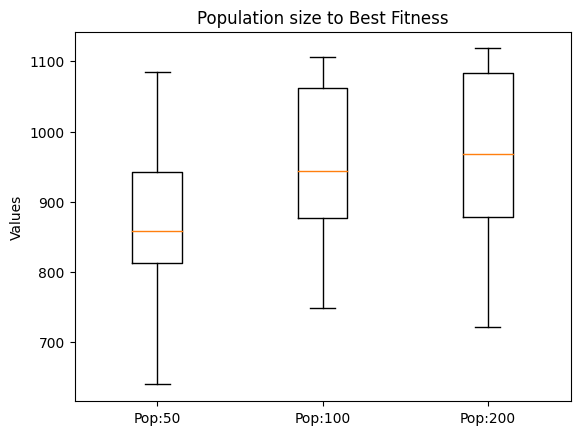

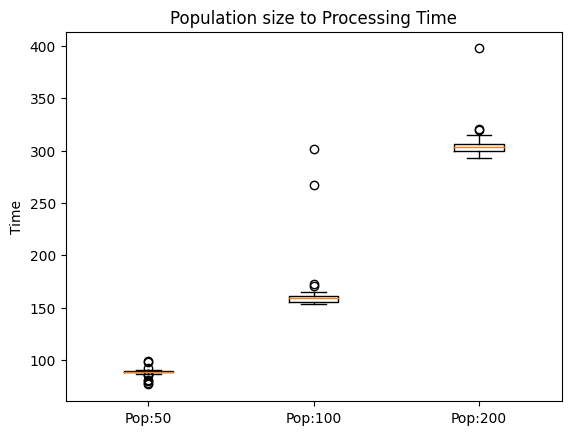

In [6]:
# multikuti
import matplotlib.pyplot as plt

fitness_values = {50:[],100:[],200:[]}
speed_values =  {50:[],100:[],200:[]}
pop_size =[50, 100, 200]

for i in pop_size:
    for j in range(50):
        start = time.time()
        ga = IslandGGA(data=train_data,num_islands=8,m_iter=25,num_iter=50,n_migrants=5,pSize=i,r_cross=0.6,r_mut=0.1,strategies=strategies,evolve_strategy="multikuti")
        ga.evolve()
        end = time.time()
        processing_time=end - start
        speed_values[i].append(processing_time)
        fitness_values[i].append(ga.globalBest.fitness_value)


# Generate some random data for three groups
#data1 = np.random.normal(0, 1, size=100)
#data2 = np.random.normal(2, 1, size=100)
#data3 = np.random.normal(5, 1, size=100)

# Combine the fitness data into a list
fitness_data = [fitness_values[i] for i in  pop_size]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(fitness_data)

# Set the x-axis tick labels
ax.set_xticklabels(['Pop:50', 'Pop:100','Pop:200'])

# Set the y-axis label
ax.set_ylabel('Values')

# Set the title of the plot
ax.set_title('Population size to Best Fitness')

# Show the plot
plt.show()

#### time plot
# Combine the fitness data into a list
speed_data = [speed_values[i] for i in  pop_size]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(speed_data)

# Set the x-axis tick labels
ax.set_xticklabels(['Pop:50', 'Pop:100','Pop:200'])

# Set the y-axis label
ax.set_ylabel('Time')

# Set the title of the plot
ax.set_title('Population size to Processing Time')

# Show the plot
plt.show()


Running master_slave
Generation 0: Best fitness = 326.292035684603 Average fitness = 192.84050678056664
Generation 1: Best fitness = 326.292035684603 Average fitness = 220.86542582948616
Generation 2: Best fitness = 326.292035684603 Average fitness = 237.18270509344424
Generation 3: Best fitness = 473.4921539504925 Average fitness = 262.5330900075423
Generation 4: Best fitness = 582.3487287722731 Average fitness = 282.28379931203324
Generation 5: Best fitness = 582.3487287722731 Average fitness = 292.3827100621957
Generation 6: Best fitness = 595.3992169213933 Average fitness = 311.9179719018403
Generation 7: Best fitness = 600.1089754110433 Average fitness = 371.4286464578079
Generation 8: Best fitness = 600.1089754110433 Average fitness = 426.8764111457326
Generation 9: Best fitness = 600.1089754110433 Average fitness = 484.716968124958
Generation 10: Best fitness = 618.9014463019281 Average fitness = 528.5764864924107
Generation 11: Best fitness = 626.6109517639314 Average fitness =

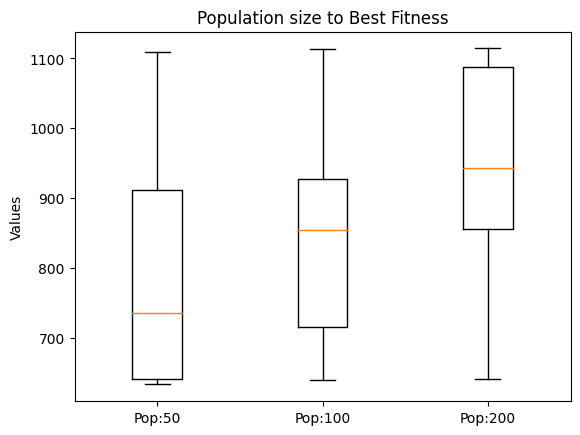

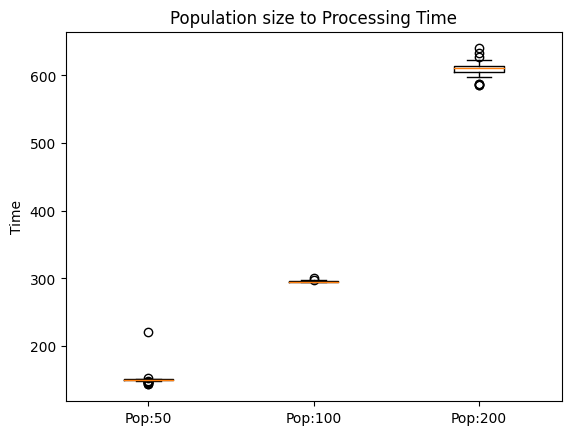

In [4]:
# master_slave
import matplotlib.pyplot as plt

fitness_values = {50:[],100:[],200:[]}
speed_values =  {50:[],100:[],200:[]}
pop_size =[50, 100, 200]

for i in pop_size:
    for j in range(50):
        start = time.time()
        ga = IslandGGA(data=train_data,num_islands=8,m_iter=25,num_iter=50,n_migrants=5,pSize=i,r_cross=0.6,r_mut=0.1,strategies=strategies,evolve_strategy="master_slave")
        ga.evolve()
        end = time.time()
        processing_time=end - start
        speed_values[i].append(processing_time)
        fitness_values[i].append(ga.globalBest.fitness_value)


# Generate some random data for three groups
#data1 = np.random.normal(0, 1, size=100)
#data2 = np.random.normal(2, 1, size=100)
#data3 = np.random.normal(5, 1, size=100)

# Combine the fitness data into a list
fitness_data = [fitness_values[i] for i in  pop_size]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(fitness_data)

# Set the x-axis tick labels
ax.set_xticklabels(['Pop:50', 'Pop:100','Pop:200'])

# Set the y-axis label
ax.set_ylabel('Values')

# Set the title of the plot
ax.set_title('Population size to Best Fitness')

# Show the plot
plt.show()

#### time plot
# Combine the fitness data into a list
speed_data = [speed_values[i] for i in  pop_size]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(speed_data)

# Set the x-axis tick labels
ax.set_xticklabels(['Pop:50', 'Pop:100','Pop:200'])

# Set the y-axis label
ax.set_ylabel('Time')

# Set the title of the plot
ax.set_title('Population size to Processing Time')

# Show the plot
plt.show()
